In [1]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-om0aejo5
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-om0aejo5
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=386214 sha256=ead44716446f2a9f63c694b406668c2ccef99be0b92fed769848ae8ee036507e
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_v23qat/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


In [2]:
!pip install torch torchvision
!pip install cython pyyaml==5.1
!pip install pycocotools
!git clone https://github.com/facebookresearch/detectron2.git
!pip install -e detectron2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=64576acdb5c7da72adb536637c1bc303c73f506629c5c8ef4a2f0506c56c4200
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 whi

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

# Scipy for calculating distance
from scipy.spatial import distance

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataDir='/content/drive/MyDrive/Damaged Cars/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='/content/COCO_val_annos.json'
mul_annFile='/content/COCO_mul_val_annos.json'
img_dir = "/content/drive/MyDrive/Damaged Cars/img"

In [4]:
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...


FileNotFoundError: ignored

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

In [6]:
dataset_dir = "/content/drive/MyDrive/Damaged Cars"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_vali", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_mul_dataset_vali", {}, os.path.join(dataset_dir,val_dir,"COCO_mul_val_annos.json"), os.path.join(dataset_dir,img_dir))

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (damage) + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 2 # only has one class (damage) + 1
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/Damaged Cars/damage_segmentation_model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg['MODEL']['DEVICE']='cuda'#or cpu
damage_predictor = DefaultPredictor(cfg)

[06/10 15:04:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Damaged Cars/damage_segmentation_model.pth ...


  pixel_mean
  pixel_std


In [9]:
cfg_mul = get_cfg()
cfg_mul.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_mul.MODEL.ROI_HEADS.NUM_CLASSES = 6  # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.RETINANET.NUM_CLASSES = 6 # only has five classes (headlamp,hood,rear_bumper,front_bumper_door) + 1
cfg_mul.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/Damaged Cars/part_segmentation_model.pth")
cfg_mul.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg_mul['MODEL']['DEVICE']='cuda' #or cpu
part_predictor = DefaultPredictor(cfg_mul)

[06/10 15:04:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Damaged Cars/part_segmentation_model.pth ...


  pixel_mean
  pixel_std


In [10]:
def detect_damage_part(damage_dict, parts_dict):
  """
  Returns the most plausible damaged part for the list of damages by checking the distance 
  between centers centers of damage_polygons and parts_polygons

  Parameters
  -------------
   damage_dict: dict
                Dictionary that maps damages to damage polygon centers.
   parts_dict: dict
                Dictionary that maps part labels to parts polygon centers.
  Return
  ----------
  part_name: str
            The most plausible damaged part name.
  """
  try:
    max_distance = 10e9
    assert len(damage_dict)>0, "AssertError: damage_dict should have atleast one damage"
    assert len(parts_dict)>0, "AssertError: parts_dict should have atleast one part"
    max_distance_dict = dict(zip(damage_dict.keys(),[max_distance]*len(damage_dict)))
    part_name = dict(zip(damage_dict.keys(),['']*len(damage_dict)))

    for y in parts_dict.keys():
        for x in damage_dict.keys():
          dis = distance.euclidean(damage_dict[x], parts_dict[y])
          if dis < max_distance_dict[x]:
            part_name[x] = y.rsplit('_',1)[0]

    return list(set(part_name.values()))
  except Exception as e:
    print(e)

In [11]:
damage_class_map= {0:'damage'}
parts_class_map={0:'headlamp',1:'rear_bumper', 2:'door', 3:'hood', 4: 'front_bumper'}

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


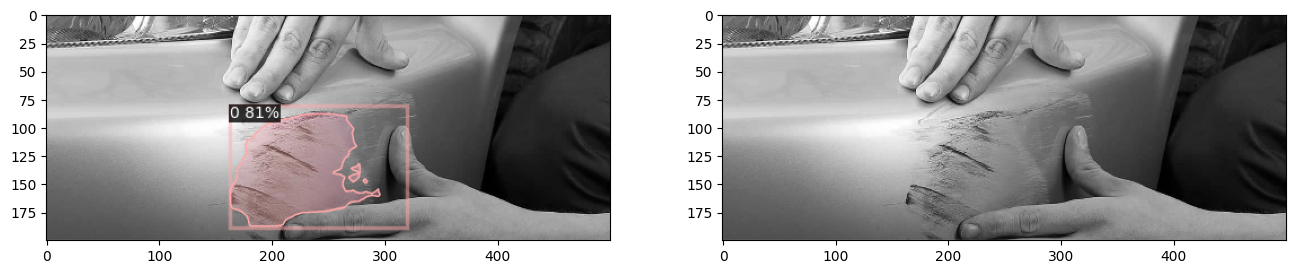

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))
im = io.imread("https://di-uploads-pod6.dealerinspire.com/carhopredesign/uploads/2018/05/Car-scratches-silver-bumper_45002223.jpg")

#damage inference
damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

#part inference
parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

#plot
ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

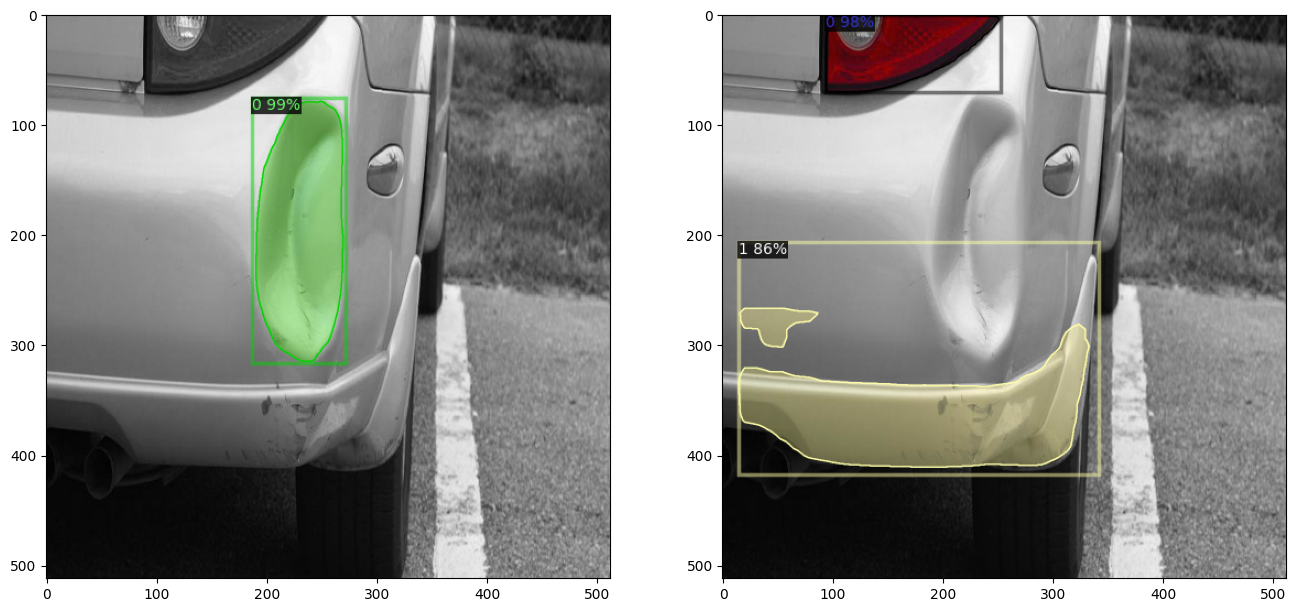

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,12))

# Load the image
im = io.imread('/content/1.jpg')

# Continue with the rest of your code

#damage inference
damage_outputs = damage_predictor(im)
damage_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
damage_out = damage_v.draw_instance_predictions(damage_outputs["instances"].to("cpu"))

#part inference
parts_outputs = part_predictor(im)
parts_v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("car_mul_dataset_val"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
parts_out = parts_v.draw_instance_predictions(parts_outputs["instances"].to("cpu"))

#plot
ax1.imshow(damage_out.get_image()[:, :, ::-1],)
ax2.imshow(parts_out.get_image()[:, :, ::-1])

In [15]:
damage_prediction_classes = [ damage_class_map[el] + "_" + str(indx) for indx,el in enumerate(damage_outputs["instances"].pred_classes.tolist())]
damage_polygon_centers = damage_outputs["instances"].pred_boxes.get_centers().tolist()
damage_dict = dict(zip(damage_prediction_classes,damage_polygon_centers))

In [16]:
parts_prediction_classes = [ parts_class_map[el] + "_" + str(indx) for indx,el in enumerate(parts_outputs["instances"].pred_classes.tolist())]
parts_polygon_centers =  parts_outputs["instances"].pred_boxes.get_centers().tolist()



#Remove centers which lie in beyond 800 units
parts_polygon_centers_filtered = list(filter(lambda x: x[0] < 800 and x[1] < 800, parts_polygon_centers))
parts_dict = dict(zip(parts_prediction_classes,parts_polygon_centers_filtered))

In [17]:
print("Damaged Parts: ",detect_damage_part(damage_dict,parts_dict))

Damaged Parts:  ['rear_bumper']
